<a href="https://colab.research.google.com/github/shams-mehdi/SPIB-plumed-masterclass-2022/blob/main/plumed_masterclass_2022_SPIB_aladip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PLUMED Masterclass 22.7: State Predictive Information Bottleneck (RAVE)**


**Authors** Pratyush Tiwary, Shams Mehdi, Dedi Wang


**Date** May 16, 2022



**Aims**

This masterclass is a continuation (part 2) of the previously introduced [ State Predictive Information Bottleneck (SPIB)](https://aip.scitation.org/doi/10.1063/5.0038198. We will show you how to train an SPIB model from data obtained from Molecular Dynamics and perform Metadynamics by biasing the SPIB learnt reaction coordinates.


**Prerequisites**

**Please change colab runtime to GPU Hardware accelerator.**

You should have a working knowledge of Python. Some familiarity with PyTorch is useful but not essential.


**Objectives**

1.   Use SPIB to analyze alanine dipeptide trajectory (in vacuum)
2.   Use SPIB to perform biased metadynamics simulations




**Step 0.a**: 
<br>Install conda and activate a conda environment. You will be prompted to manually type in y (for yes).

In [ ]:
# INSTALL CONDA ON GOOGLE COLAB
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

# Create conda environemt
!conda create --name plumed-masterclass-2022

**Step 0.b**: 
<br>Activate conda environment

In [ ]:
# Activate conda environment
%%bash
source activate plumed-masterclass-2022

**Step 0.c**: 
<br>Install plumed, and a specific verion of Gromacs (2018.6) pre-patched with plumed, and other libraries

In [ ]:
!conda install -c anaconda numpy -y
!conda install -c conda-forge matplotlib -y
!conda install -c pytorch pytorch -y
!conda install -c plumed/label/lugano -c conda-forge plumed -y
!conda install -c plumed/label/lugano -c conda-forge gromacs=2018.6 -y

**Step 0.d**: 
<br>Load necessary python libraries and matplotlib graph visualization parameters.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
import importlib.util
import sys
import pandas as pd

sys.path.append('SPIB_scripts/')
np.random.seed(42)

large = 24; med = 12; small = 8
l_width = 3; m_width = 1.5; s_width = 0.7
params = {'axes.titlesize': large,
          'legend.fontsize': large,
          'legend.title_fontsize':large,
          'figure.figsize': (16, 10),
          'axes.labelsize': large,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'lines.linewidth': l_width,
          'lines.markersize': 2,
          'axes.linewidth': l_width,
          'xtick.major.size': 8,
          'ytick.major.size': 8,
          'xtick.minor.size': 4,
          'ytick.minor.size': 4,
          'xtick.major.width': m_width,
          'ytick.major.width': m_width,
          'xtick.minor.width': s_width,
          'ytick.minor.width': s_width,
          'grid.linewidth': m_width}
plt.rcParams.update(params)

**Step 1**: 
<br>Clone the github repository containing necessary files for this tutorial. The SPIB directory includes SPIB (ver July, 2021) scripts. Other files include:<br>
**aladip_inputs/aladip.gro** : Molecular structure of alanine dipeptide (in vacuum)<br>
**aladip_inputs/aladip.mdp** : Molecular dynamics parameters (.mdp) for running simulation in gromacs<br>
**aladip_inputs/aladip.top** : Gromacs compatible topology file<br>
**aladip_inputs/aladip_unbiased_trajectory.npy**: (φ, ψ, θ, ω) dihedral angles for alanine dipeptide in vacuum trajectory (length: 20.0 ns, T: 450K, data resolution: 0.05 ps)<br>
**aladip_inputs/header.txt** : Header text for creating a plumed.dat file based on SPIB learned reaction coordinate<br>

In [ ]:
!npx degit shams-mehdi/SPIB-plumed-masterclass-2022 -f

npx: installed 1 in 1.207s
> destination directory is not empty. Using --force, continuing
> cloned shams-mehdi/SPIB-plumed-masterclass-2022#HEAD


**Step 2**:
<br>Load the unbiased trajectory -> visualize (φ, ψ) time series for the first 100.0 ps -> create a free energy plot for the entire trajectory.

Number of saved frames:  2000000 , Number of features:  4


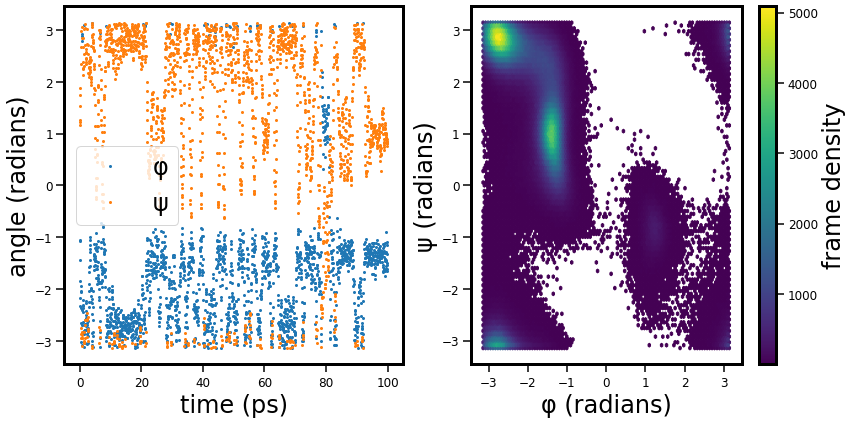

In [54]:
traj_raw = np.load("aladip_inputs/aladip_unbiased_trajectory.npy")
print('Number of saved frames: ', traj_raw.shape[0], ', Number of features: ', traj_raw.shape[1])

## Loaded numpy arrays contain datapoints saved every 0.05ps. The first 2000 steps (100.00 ps) are selected for time series visualization
data_resolution = 0.05
datapoints_tseries = 2000
time = np.arange(datapoints_tseries)*data_resolution

fig, ax = plt.subplots(1, 2, figsize = (12,6))
## Time Series plot
ax[0].plot(time, traj_raw[:datapoints_tseries,0], 'o', label = 'φ')
ax[0].plot(time, traj_raw[:datapoints_tseries,1], 'o', label = 'ψ')
ax[0].set_xlabel('time (ps)')
ax[0].set_ylabel('angle (radians)')
ax[0].legend()

## FES plot of entire trajectory
fes = ax[1].hexbin(traj_raw[:,0], traj_raw[:,1], mincnt=1)
ax[1].set_xlabel('φ (radians)')
ax[1].set_ylabel('ψ (radians)')
cb = fig.colorbar(fes, ax=ax[1])
cb.set_label('frame density')
fig.tight_layout()

**Step 3**:<br>
Assign initial states by binning data along φ dihedral angle. Create 8 OP SPIB input data (sin-cos of φ, ψ, θ, ω) from (φ, ψ, θ, ω) trajectory.

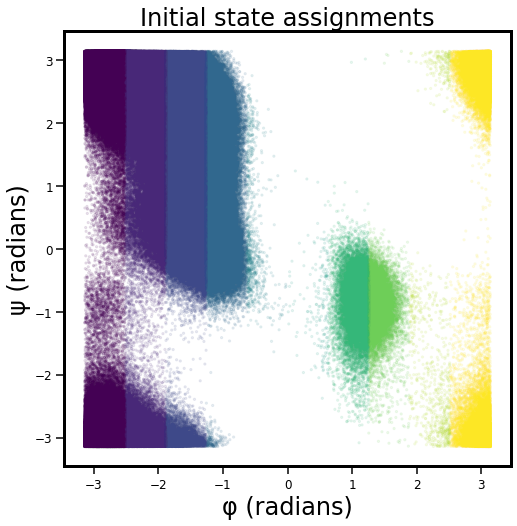

In [ ]:
#@title One-hot encoded initial state assignment
num_labels = 10 #@param {type:"integer"}
# 10 initial states assigned to the trajectory by binning along φ

# Creating one hot vectors for initial states
bins = np.linspace(start = -np.pi, stop = np.pi, num = num_labels, endpoint = False)
binned_data = np.digitize(traj_raw[:,0], bins)-1
one_hot_labels = np.zeros((traj_raw.shape[0], num_labels))
one_hot_labels[np.arange(traj_raw.shape[0]),binned_data] = 1

# Save one-hot encoded initial states
np.save("aladip_inputs/labels.npy", one_hot_labels)

# Visualize initial states
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(traj_raw[:, 0], traj_raw[:, 1], c=binned_data, s=5, alpha=.1)
ax.set_title('Initial state assignments')
ax.set_xlabel('φ (radians)')
ax.set_ylabel('ψ (radians)')

# Create and save 8 OP SPIB input
traj_sincos = np.zeros((traj_raw.shape[0], 2*traj_raw.shape[1]))
for i in range(traj_raw.shape[1]):
  traj_sincos[:, 2*i] = np.sin(traj_raw[:, i])
  traj_sincos[:, 2*i + 1] = np.cos(traj_raw[:, i])

np.save('aladip_inputs/trajectory_sincos.npy', traj_sincos)

**Step 4**:<br>
Train a nonlinear SPIB (ver July, 2021) model by choosing appropriate hyperparmeters.

---

Time delay = dt*0.05 ps, heuristic for batch size = 0.1% of trajectory length

In [31]:
#@title Select SPIB hyperparameters
## Train an SPIB model with time delay = 0.25 ps

dt = 5 #@param {type:"integer"}
rc_dim = 2 #@param {type:"integer"}
encoder_type = 'Nonlinear' #@param {type:"string"}
neuron_num1 = 16 #@param {type:"integer"}
neuron_num2 = 16 #@param {type:"integer"}
## heuristic for batch size is to set it ~ 0.1% of the trajectory length
batch_size = 2048 #@param {type:"integer"}
refinements = 15 #@param {type:"integer"}
learning_rate = 0.0001 #@param {type:"number"}
beta = 0.001 #@param {type:"number"}
seed = 0 #@param {type:"integer"}
traj_path = 'aladip_inputs/trajectory_sincos.npy'
initial_states_path = 'aladip_inputs/labels.npy'
SPIB_OPs = traj_sincos.shape[1]
Weighted_or_not = "Unweighted"

In [ ]:
# Train SPIB model
!python SPIB_scripts/test_model.py -dt {dt} -d {rc_dim} -encoder_type {encoder_type} -bs {batch_size} -n1 {neuron_num1} -n2 {neuron_num2} -refinements {refinements} -lr {learning_rate} -b {beta} -seed {seed} -label {initial_states_path} -traj {traj_path}

**Step 5**:
<br>Visualize converged SPIB states

Text(0, 0.5, 'ψ (radians)')

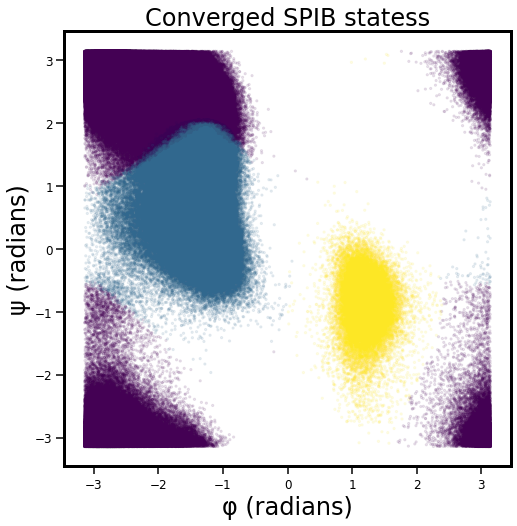

In [ ]:
## Number of trajectories in this analysis
num_traj = 1
## Construct file path from chosen hyperparameter values
path = "SPIB/" + Weighted_or_not + "_d=" + str(rc_dim) + "_t=" + str(dt) + "_b=" + "{:.4f}".format(beta) + "_learn=" + "{:.6f}".format(learning_rate)

one_hot_converged_labels = np.load(path + "_traj" + str(num_traj-1) + "_labels" + str(seed) + ".npy")
converged_labels = np.zeros((one_hot_converged_labels.shape[0]), dtype = 'int')

for i in range(converged_labels.shape[0]):
  converged_labels[i] = np.nonzero(one_hot_converged_labels[i,:])[0]

fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(traj_raw[:, 0], traj_raw[:, 1], c=converged_labels, s=5, alpha=.1)
ax.set_title('Converged SPIB statess')
ax.set_xlabel('φ (radians)')
ax.set_ylabel('ψ (radians)')

**Step 6**: Create plumed input from saved SPIB model

In [42]:
# Note: When encountering following error: "module SPIB has no attribute SPIB", restart runtime and run all except SPIB training cell.
#@title Metadynamics parameters
sigma_mul = 0.2 #@param {type:"number"}
grid_mul = 5 #@param {type:"number"}
height = 1.5 #@param {type:"number"}
bias_factor = 10 #@param {type:"number"}
pace = 2000 #@param {type:"integer"}
stride = 100 #@param {type:"integer"}
grid_bins = 500 #@param {type:"integer"}
file_name = "plumed_SPIB_aladip.dat" #@param {type:"string"}

import torch
from torch import nn
import SPIB


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = "SPIB/" + Weighted_or_not + "_d=" + str(rc_dim) + "_t=" + str(dt) + "_b=" + "{:.4f}".format(beta) + "_learn=" + "{:.6f}".format(learning_rate)

data_shape=SPIB_OPs
# Update Label should be set to False for testing purposes only
UpdateLabel = True
# Load patameters from SPIB checkpoint
restore_path= path + 'cpt0/IB_final_cpt.pt'
representative_inputs_path=path + '_representative_inputs' + str(seed) + '.npy'
representative_inputs = torch.tensor(np.load(representative_inputs_path))
IB = SPIB.SPIB(encoder_type, rc_dim, num_labels, data_shape, device, UpdateLabel, neuron_num1, neuron_num2)
IB.reset_representative(representative_inputs)
checkpoint=torch.load(restore_path)
IB.load_state_dict(checkpoint['state_dict'])

weight0=IB.encoder[0].weight.cpu().data.numpy()
weight1=IB.encoder[2].weight.cpu().data.numpy()
weight2=IB.encoder_mean.weight.cpu().data.numpy()
bias0=IB.encoder[0].bias.cpu().data.numpy()
bias1=IB.encoder[2].bias.cpu().data.numpy()
bias2=IB.encoder_mean.bias.cpu().data.numpy()

with open('aladip_inputs/header.txt', 'r') as f:
  head = f.read()
header = head + "\n"

## Calculate standard deviation of the RC and mutiply by sigma_mul to obtain sigma for metadynamics
traj_rc = np.load(path + "_traj" + str(num_traj-1) + "_mean_representation" + str(seed) + ".npy")
rc1_sigma = np.std(traj_rc[:,0])*sigma_mul
rc2_sigma = np.std(traj_rc[:,1])*sigma_mul  

## Set grid_min and grid_max
rc1_grid_min = np.min(traj_rc[:,0]) - grid_mul*rc1_sigma
rc2_grid_min = np.min(traj_rc[:,1]) - grid_mul*rc1_sigma

rc1_grid_max = np.max(traj_rc[:,0]) + grid_mul*rc1_sigma
rc2_grid_max = np.max(traj_rc[:,1]) + grid_mul*rc1_sigma

dihedrals = ['phi', 'psi', 'theta', 'omega']
with open(file_name, 'w') as f:
    f.writelines(header)
    f.write('\n')
    
    input_OPs = ''
    for i in dihedrals:
      input_OPs += "sin_" + i + ",cos_" + i +","
    # 1st layer
    for i in range(weight0.shape[0]):
        toprint = f"l1_{i+1}: COMBINE ARG=" + input_OPs   
        toprint = toprint[:-1] + " COEFFICIENTS="
        for j in range(weight0.shape[1]):
            toprint = toprint + "%0.12f," % (weight0[i,j])
        toprint = toprint[:-1] + " PERIODIC=NO\n"
        f.write(toprint)
    for i in range(weight0.shape[0]):
        onebias = bias0[i]
        # Relu as activation function
        if onebias >= 0:
            printfun = "step(x+%0.12f)*(x+%0.12f)" % (onebias,onebias)
        else:
            printfun = "step(x-%0.12f)*(x-%0.12f)" % (-onebias,-onebias)
        f.write("l1r_%i: MATHEVAL ARG=l1_%i FUNC=%s PERIODIC=NO\n" % (i+1,i+1,printfun))
    
    # 2nd layer
    for i in range(weight1.shape[0]):
        toprint = "l2_%i: COMBINE ARG=" % (i+1)
        for j in range(weight0.shape[0]):
          toprint = toprint + "l1r_%i," % (j+1)
        toprint = toprint[:-1] + " COEFFICIENTS="
        for j in range(weight0.shape[0]):
          toprint = toprint + "%0.12f," % (weight1[i,j])
        toprint = toprint[:-1] + " PERIODIC=NO\n"
        f.write(toprint)
    for i in range(weight1.shape[0]):
        onebias = bias1[i]
        # Relu as activation function
        if onebias >= 0:
            printfun = "step(x+%0.12f)*(x+%0.12f)" % (onebias,onebias)
        else:
            printfun = "step(x-%0.12f)*(x-%0.12f)" % (-onebias,-onebias)
        f.write("l2r_%i: MATHEVAL ARG=l2_%i FUNC=%s PERIODIC=NO\n" % (i+1,i+1,printfun))
        
    # 3rd layer/Linear Output
    for i in range(weight2.shape[0]):
        toprint = "l3_%i: COMBINE ARG=" % (i+1)
        for j in range(weight1.shape[0]):
          toprint = toprint + "l2r_%i," % (j+1)
        toprint = toprint[:-1] + " COEFFICIENTS="
        for j in range(weight1.shape[0]):
          toprint = toprint + "%0.12f," % (weight2[i,j])
        toprint = toprint[:-1] + " PERIODIC=NO\n"
        f.write(toprint)
    
    output_variable=''
    for i in range(weight2.shape[0]):
        output_variable=output_variable+"l3_%i," % (i+1)
    output_variable=output_variable[:-1]
    
    f.write(f'\nMETAD ...\nLABEL=metad\nARG='+output_variable+f' SIGMA={rc1_sigma},{rc2_sigma} HEIGHT={height} BIASFACTOR={bias_factor} TEMP=450.0 PACE={pace}\nGRID_MIN={rc1_grid_min},{rc2_grid_min} GRID_MAX={rc1_grid_max},{rc2_grid_max} \nCALC_RCT\n... METAD\n')
    f.write('\n')
            
    f.write('\nPRINT ARG='+input_OPs+output_variable+',metad.bias,metad.rbias'+f' STRIDE={stride} FILE=COLVAR')

**Step 7:** Perform 2.5 ns SPIB augmented metadynamics

In [ ]:
!gmx grompp -f aladip_inputs/aladip.mdp -o aladip_inputs/aladip.tpr -c aladip_inputs/aladip.gro -p aladip_inputs/aladip.top -maxwarn -1

In [ ]:
!gmx mdrun -v -deffnm aladip_inputs/aladip --plumed plumed_SPIB_aladip.dat -ntomp 1

In [ ]:
!head COLVAR

**Step 8:** Convert metadynamics output into a numpy array and visualize SPIB augmentented metadynamics result

In [ ]:
metad_traj = np.loadtxt("COLVAR")
## 8 OP SPIB-metadynamics COLVAR is converted into 4 OP numpy array 
metad_dihedrals = np.zeros((metad_traj.shape[0], 4))
for i in range(4):
  metad_dihedrals[:,i] = np.arctan2(metad_traj[:, 2*i], metad_traj[:, 2*i + 1])

metad_data_resolution = stride * 0.002
metad_time = np.arange(metad_dihedrals.shape[0])*metad_data_resolution

fig, ax = plt.subplots(figsize = (6,6))
## Time Series plot
ax.plot(metad_time, metad_dihedrals[:,0], 'o', label = 'φ')
ax.plot(metad_time, metad_dihedrals[:,1], 'o', label = 'ψ')
ax.set_xlabel('time (ps)')
ax.set_ylabel('angle (radians)')
ax.legend()
fig.tight_layout()

**Note**: Advanced users may improve SPIB augmented metadynamics performance by upto 30%, by employing libtorch implementation of plumed. If interested please feel free to get in touch and we would be happy to help.